In [1]:
# 1. LIBRARY IMPORTS
import os, re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [2]:
# 2. SETUP DIRECTORIES
os.makedirs('data', exist_ok=True)
os.makedirs('results/visualizations', exist_ok=True)

In [3]:
# 3. LOAD DATA & CREATE SENTIMENT LABELS
try:
    df = pd.read_csv('data/SHOPEE_REVIEWS.csv')[['review_text', 'review_rating', 'review_datetime_utc']].dropna(subset=['review_text'])

    def to_sentiment(rating):
        r = int(rating)
        return 'Negative' if r <= 2 else 'Positive' if r >= 4 else 'Neutral'

    df['sentiment'] = df['review_rating'].apply(to_sentiment)
except FileNotFoundError:
    print("\nERROR")
    exit()

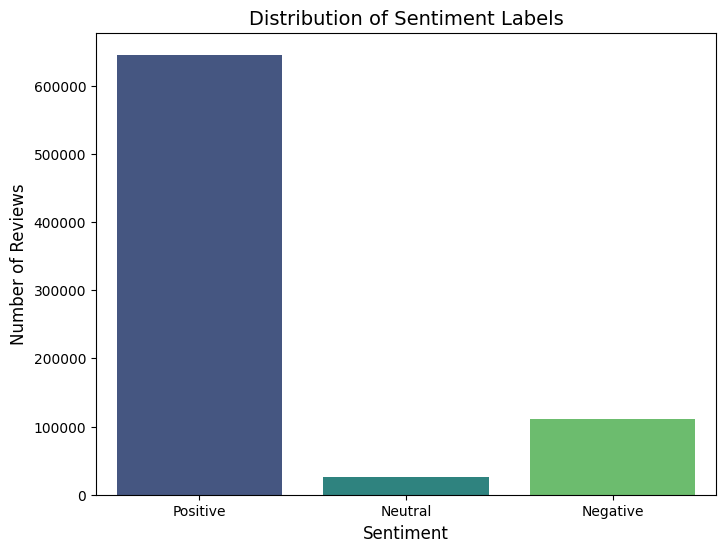


Distribution of sentiments (%):
sentiment
Positive    82.552140
Negative    14.163292
Neutral      3.284568
Name: proportion, dtype: float64


In [4]:
# 4. CHECK LABEL DISTRIBUTION

df_clean = df.copy()

plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df_clean, hue='sentiment', palette='viridis', order=['Positive', 'Neutral', 'Negative'], legend=False)
plt.title('Distribution of Sentiment Labels', fontsize=14)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.show()

print("\nDistribution of sentiments (%):")
print(df_clean['sentiment'].value_counts(normalize=True) * 100)

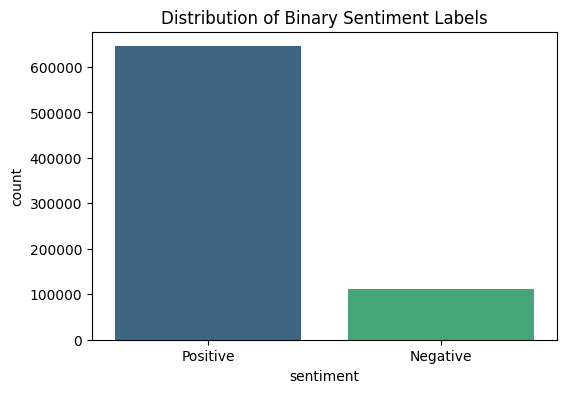

Dataset ready: 756158 rows.

Distribution of sentiments (%):
sentiment
Positive    85.355706
Negative    14.644294
Name: proportion, dtype: float64


In [5]:
# 5. FILTER BINARY SENTIMENT
df_binary = df[df['sentiment'] != 'Neutral'].copy()


# Visualize class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='sentiment', data=df_binary, hue='sentiment', palette='viridis', order=['Positive', 'Negative'])
plt.title('Distribution of Binary Sentiment Labels')
plt.savefig('results/visualizations/sentiment_distribution.png')
plt.show()

print(f"Dataset ready: {len(df_binary)} rows.")
print("\nDistribution of sentiments (%):")
print(df_binary['sentiment'].value_counts(normalize=True) * 100)

In [6]:
# 6. TEXT PREPROCESSING
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if not isinstance(text, str): return ""
    text = re.sub(r'[^a-z\s]', '', text.lower())
    return " ".join([w for w in text.split() if w not in stop_words])

df_binary['processed_text'] = df_binary['review_text'].apply(preprocess_text)
print("🧹 Text preprocessing completed.")
print(df_binary[['review_text', 'processed_text']].head(10))

🧹 Text preprocessing completed.
                                         review_text  \
0  The next level in buying and selling! Everyone...   
1                      User friendly ecommerce site.   
2  This is such a cool app. I find it easy to bro...   
3                     Finally, they're here! Hooray!   
4  Very cool app. Shop anytime, anywhere. Hassle-...   
5  Great new app! Definitely helpful for finding ...   
6  Nice! A very convenient app for a online shopp...   
7                                      Amazing app!!   
8                                            Love it   
9  Buy and sell online made easy and secured. Gre...   

                                      processed_text  
0  next level buying selling everyone try must ap...  
1                       user friendly ecommerce site  
2  cool app find easy browse might skip going mal...  
3                              finally theyre hooray  
4  cool app shop anytime anywhere hasslefree buyi...  
5  great new app defi

In [7]:
# 7. VECTORIZE TEXT & SPLIT DATA
X = df_binary['processed_text']
y = df_binary['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


Evaluation Report
              precision    recall  f1-score   support

    Negative       0.69      0.86      0.77     22147
    Positive       0.97      0.94      0.95    129085

    accuracy                           0.92    151232
   macro avg       0.83      0.90      0.86    151232
weighted avg       0.93      0.92      0.93    151232



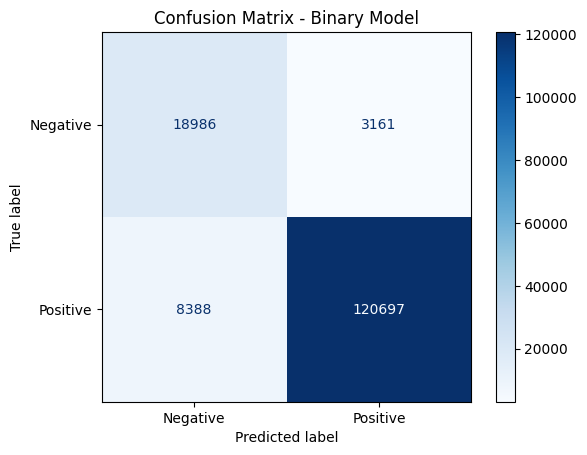

In [8]:
# 8. TRAIN MODEL & EVALUATE
model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
model.fit(X_train_tfidf, y_train)
preds = model.predict(X_test_tfidf)

print("\nEvaluation Report")
print(classification_report(y_test, preds))

ConfusionMatrixDisplay.from_predictions(y_test, preds, cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Binary Model')
plt.grid(False)
plt.savefig('results/visualizations/confusion_matrix.png')
plt.show()

In [9]:
# 9. EXPORT RESULTS
final_df = df_binary.loc[X_test.index].copy()
final_df['predicted_sentiment'] = preds
final_df.to_csv('results/sentiment_analysis_results.csv', index=False)
print("\nFile exported to 'results/sentiment_analysis_results.csv'.")


File exported to 'results/sentiment_analysis_results.csv'.
